# 大相撲の試合の予測


このノートでは、大相撲のデータセットを分析していきます。ウェブサイト[Data World](https://data.world/cervus/sumo-japan) 」には、相撲の試合結果のデータセット、1983年以降の力士の特性のデータセット、2017年以降の試合の勝算のデータセットがあります。


それぞれの変数についての説明は[こちら](https://data.world/cervus/sumo-japan/workspace/data-dictionary)をご覧ください。


## 目的

大相撲の試合の結果を予測すること。

### 目次

<b>1.データ分析</b>
* 1.1.基本的な分析。
* 1.2.行方不明のデータ。
* 1.3.最も勝利数の多い人の選手は誰か。
* 1.4.大相撲の力士の身長と体重。
* 1.5.最も多く力士を育てたのはどこの部屋か。
* 1.6.大相撲の力士はどこの出身ですか。

<b>2.正確な勝算</b>
* 2.1.勝算と結果の変数のための新しい変数。
* 2.2.勝算と結果のデータフレームのための新しい変数。
* 2.3.結果。

<b>3.試合結果の予測</b>
* 3.1.試合結果の予測。
* 3.2.トレーニングとテストのためのデータ分割。
* 3.3.モデリング。

In [2]:
#インポート
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

[GitHub](https://github.com/ElieSDK/Sumo_Match_Prediction/tree/main/Data)でもデータセットをダウンロードができます。

In [3]:
#データセットを読みます
banzuke = pd.read_csv('banzuke.csv')
odds = pd.read_csv('odds.csv')
results = pd.read_csv('results.csv')

## 1.データ分析
### 1.1.基本的な分析

In [89]:
#最初のデータフレームを確認します
banzuke.head()

,basho,id,rank,rikishi,heya,shusshin,birth_date,height,weight,prev,prev_w,prev_l
0,1983.01,1354,Y1e,Chiyonofuji,Kokonoe,Hokkaido,1955-06-01,182.0,116.0,Y1e,14.0,1.0
1,1983.01,4080,Y1w,Kitanoumi,Mihogaseki,Hokkaido,1953-05-16,179.0,165.0,Y2eHD,9.0,3.0
2,1983.01,4095,Y2eHD,Wakanohana,Futagoyama,Aomori,1953-04-03,186.0,133.0,Y1w,0.0,0.0
3,1983.01,4104,O1e,Takanosato,Futagoyama,Aomori,1952-09-29,181.0,144.0,O1e,10.0,5.0
4,1983.01,4112,O1w,Kotokaze,Sadogatake,Mie,1957-04-26,183.0,163.0,O1w,10.0,5.0


番付データベースには、1983年から2021年までの各大会について、日付、力士名、番号ID、各力士の部屋、出身地、生年月日、身長、体重、番付、前座が含まれています。

In [90]:
odds.head()

,rikishi1,odds1,rikishi2,odds2,ts
0,Arawashi,1.8,Ura,2.01,2017-05-13 09:00:01
1,Daishomaru,1.9,Onosho,1.90,2017-05-13 09:00:01
2,Goeido,1.3,Okinoumi,3.52,2017-05-13 09:00:01
3,Hakuho,1.1,Chiyonokuni,7.00,2017-05-13 09:00:01
4,Harumafuji,1.4,Kotoshogiku,2.96,2017-05-13 09:00:01


勝算データベースには、2017年から2021年までの各戦いの勝算が含まれます。勝算は時間の経過とともに微妙に変化するため、1つの試合が多くの勝算を持つことがあります。

In [91]:
results.head()

,basho,day,rikishi1_id,rikishi1_rank,rikishi1_shikona,rikishi1_result,rikishi1_win,kimarite,rikishi2_id,rikishi2_rank,rikishi2_shikona,rikishi2_result,rikishi2_win
0,1983.01,1,4140,J13w,Chikubayama,0-1 (7-8),0,yorikiri,4306,Ms1e,Ofuji,1-0 (6-1),1
1,1983.01,1,4306,Ms1e,Ofuji,1-0 (6-1),1,yorikiri,4140,J13w,Chikubayama,0-1 (7-8),0
2,1983.01,1,1337,J12w,Tochitsukasa,1-0 (9-6),1,oshidashi,4323,J13e,Shiraiwa,0-1 (3-12),0
3,1983.01,1,4323,J13e,Shiraiwa,0-1 (3-12),0,oshidashi,1337,J12w,Tochitsukasa,1-0 (9-6),1
4,1983.01,1,4097,J12e,Tamakiyama,0-1 (8-7),0,yorikiri,4319,J11w,Harunafuji,1-0 (5-10),1


結果データベースには、1983年から2021年までの各対戦の結果が含まれます。力士の現在の順位や、勝ち技などの情報もあります。

In [92]:
banzuke.describe(include=['O'])

,rank,rikishi,heya,shusshin,birth_date,prev
count,169105,169105,169105,169105,168442,169026
unique,995,5890,73,74,4199,996
top,Ms41w,Hokutoryu,Sadogatake,Tokyo,1970-11-22,Mz
freq,230,218,8098,12711,282,4816


この関数によると、番付データベースには、74都市、73部屋、5890人のユニークな力士が含まれます。

### 1.2.行方不明のデータ

In [93]:
banzuke.isnull().sum(axis = 0)

basho            0
id               0
rank             0
rikishi          0
heya             0
shusshin         0
birth_date     663
height        5174
weight        5174
prev            79
prev_w          79
prev_l          79
dtype: int64

主に身長と体重に関するデータが欠落しています。データベース(169,105行)に対して欠落データはわずかなので、これらの欠落情報を持つ行を削除します:

In [4]:
banzuke = banzuke.dropna()

### 1.3.最も勝利数の多い人の選手は誰か

まず、欠落した情報を取り除いた後に、何人のユニークな力士がいるか見ます:

In [11]:
unique_id = banzuke.drop_duplicates(subset=['id'])
print("ユニークな力士の数は",unique_id['id'].count(),"人です。")

ユニークな力士の数は 4949 人です。


結果のデータフレームから、力士を勝利数の多い順に並べることができます。

In [83]:
results[['rikishi1_shikona', 'rikishi1_win']].groupby(['rikishi1_shikona'],
                                      as_index=False).count().sort_values(
                                          by='rikishi1_win',ascending=False).head(n=10)

,rikishi1_shikona,rikishi1_win
361,Kyokutenho,1715
14,Aminishiki,1700
236,Kaio,1662
604,Terao,1580
624,Tochinowaka,1518
682,Wakanosato,1467
649,Tosanoumi,1444
332,Kotonowaka,1428
577,Takekaze,1419
336,Kotoshogiku,1399


4949人の力士の中で、最も多くの勝ち星をあげているのは、旭天鵬で(Kyokutenho)、1715回の勝ち星をあげています。

### 1.4.大相撲の力士の身長と体重

In [7]:
print("相撲の平均身長は",round(banzuke["height"].mean(),1),"センチです。")

相撲の平均身長は 179.6 センチです。


In [8]:
print("相撲の平均体重は",round(banzuke["weight"].mean(),1),"キロです。")

相撲の平均体重は 125.2 キロです。


力士の平均身長は179.6センチ、平均体重は125.2キロです。

力士の名前を入れると、その力士の身長と体重の推移を描くことができます。<br>
今回の例では、大相撲の大内選手(Osonai)に決めました。

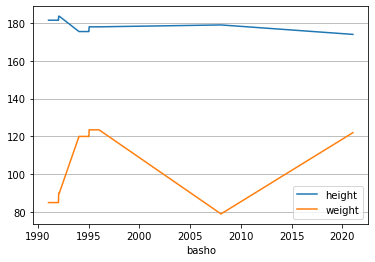

In [47]:
sumo_HW = banzuke.loc[banzuke['rikishi'] == 'Osanai']
sumo_HW.plot(x="basho", y=["height", "weight"], kind="line")
plt.grid(axis='y', linestyle='-')

2008年からの30年間で、身長はわずかに減少しました。一方、体重は85kgから120kgまで変化しました。

どの部屋に平均して最も背が高く、最も重い力士がいるかを探しましょう:

In [48]:
banzuke[['height', 'heya']].groupby(['heya'],
                                      as_index=False).mean().sort_values(
                                          by='height',ascending=False).head(n=15)

,heya,height
63,Takekuma,185.870000
36,Nakadachi,182.223810
22,Kataonami,181.803420
18,Kabutoyama,181.474161
23,Kiriyama,181.179685
65,Tatsunami,181.125287
5,Azumazeki,181.069661
11,Hanakago,180.974734
58,Taiho,180.912208
48,Oshima,180.811368


身長の違いはわずかで、力士の身長は平均180cmから185cm、武隈部屋の平均は185cmです。

In [49]:
banzuke[['weight', 'heya']].groupby(['heya'],
                                      as_index=False).mean().sort_values(
                                          by='weight',ascending=False).head(n=15)

,heya,weight
63,Takekuma,166.220000
68,Tokiwayama,144.174194
6,Chiganoura,140.242820
24,Kise,139.321056
14,Irumagawa,136.884796
60,Takanohana,136.619062
71,Yamahibiki,135.281737
5,Azumazeki,134.846962
25,Kitanoumi,132.280533
53,Sakaigawa,132.196249


どうして初代と二代の部屋でこれほどの差があるのでしょうか？<br>

武隈部屋について詳しく見てみましょう。<br>
データセットには、武隈部屋の相撲試合は何試合あるのでしょうか。

In [50]:
banzuke['heya'].value_counts(ascending=True)

Tokiwayama      31
Takekuma        50
Oyama           94
Nishiiwa       120
Nakadachi      126
              ... 
Kokonoe       5058
Takasago      5276
Dewanoumi     5684
Kasugano      6196
Sadogatake    7859
Name: heya, Length: 72, dtype: int64

武隈部屋の力士が出場したのは50試合だけで、力士は黒姫山1人だけのようです。

In [51]:
banzuke.loc[banzuke['heya'] == 'Takekuma', 'rikishi'].unique()

array(['Haguronada', 'Haguroshima', 'Hagurokuni'], dtype=object)

2004年4月に書かれたこの[記事によると、](https://www-info--sumo-net.translate.goog/forum/content/380-La-Takekuma-beya-c-est-fini%21?s=746eab80535851b5db86619ecc5d5180&_x_tr_sch=http&_x_tr_sl=fr&_x_tr_tl=ja&_x_tr_hl=fr&_x_tr_pto=wapp) 確かにこの部屋には力士が一人しかいませんでした。<br>
武隈親方（...）は同名の部屋を閉鎖することを決めました。唯一の弟子である黒姫山のキャリアが終わった後、弟子なしで部屋を存続させることが困難になりました。

### 1.5.最も多く力士を育てたのはどこの部屋か

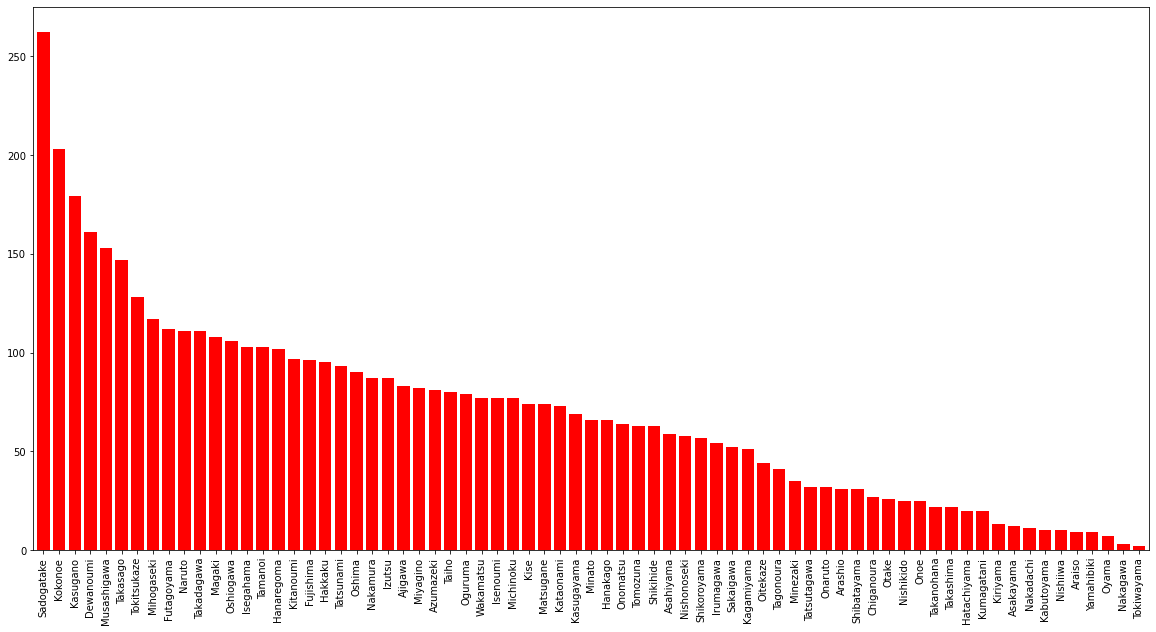

In [52]:
unique_id['heya'].value_counts().plot(kind="bar", 
                                     legend=False,
                                     color='red',
                                     width=0.8, 
                                     figsize=(20,10))
plt.show()

最も多くの力士を育てている部屋は佐渡ヶ嶽、九重、春日野です。

### 1.6.大相撲の力士はどこの出身ですか

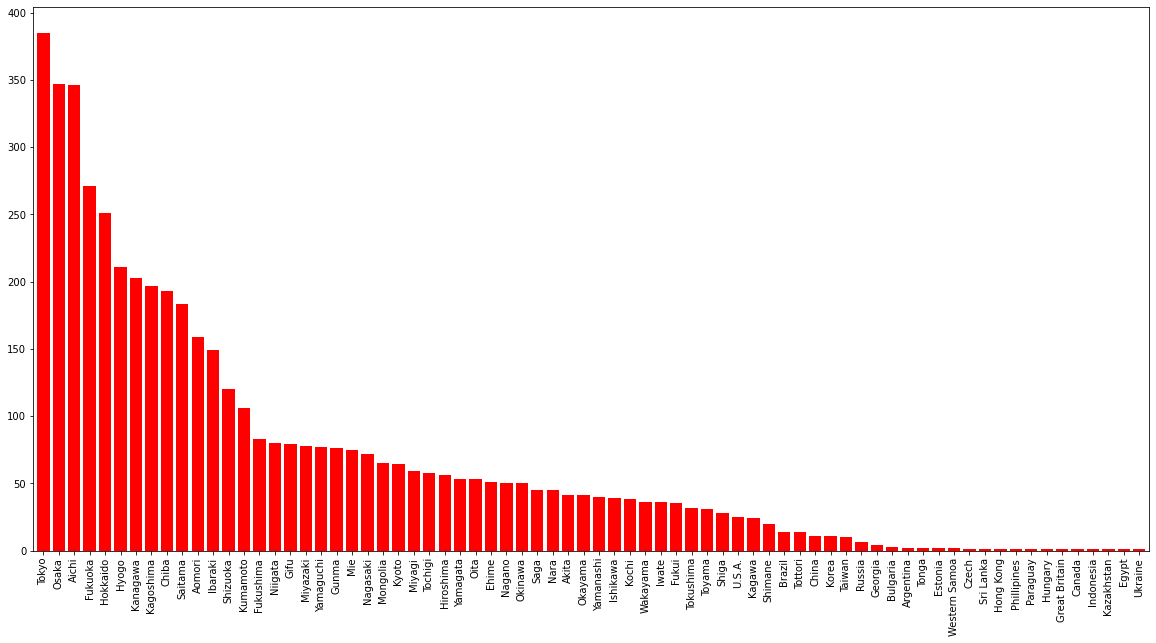

In [53]:
unique_id['shusshin'].value_counts().plot(kind="bar", 
                                     legend=False,
                                     color='red',
                                     width=0.8, 
                                     figsize=(20,10))
plt.show()

相撲は主に東京、大阪、愛知から来ています。各部屋には外国人力士を一人育成する権利がありますので、外国人力士もいます。

## 2.正確な勝算
ブックメーカーの勝算が正確かどうかを調べるために、勝算と結果のデータフレームに新しい変数を作成します。<br>

### 2.1.勝算と結果の変数のための新しい変数。
勝算のデータフレームの場合。<br>

第一力士のが第二力士の勝算よりも大きい場合: yyyy.mm.rikishi1>rikishi2<br>
それ以外の場合は yyy.mm.rikishi2>rikishi1<br>
(備考、力士は月に1回(1ヶ月に1回の場所)でしか会えませんが、1年に何度も会うことができます。)

In [5]:
odds['merged_odds'] = np.where(odds['odds1']>odds['odds2'],
                               odds['ts'].str[:7] + "." + odds['rikishi1'] + ">" + odds['rikishi2'], 
                               odds['ts'].str[:7] + "." + odds['rikishi2'] + ">" + odds['rikishi1'])

イコールがある場合は:

In [6]:
odds['merged_odds'] = np.where(odds['odds1'] == odds['odds2'],
                               odds['ts'].str[:7] + "." + odds['rikishi1'] + "=" + odds['rikishi2'],
                               odds['merged_odds'])

odds['merged_odds'] = odds['merged_odds'].str.replace('-','.')

In [56]:
odds['merged_odds']

0                  2017.05.Ura>Arawashi
1             2017.05.Daishomaru=Onosho
2               2017.05.Okinoumi>Goeido
3            2017.05.Chiyonokuni>Hakuho
4        2017.05.Kotoshogiku>Harumafuji
                      ...              
20019     2021.01.Shimanoumi>Takarafuji
20020        2021.01.Takanosho>Takayasu
20021         2021.01.Meisei>Terunofuji
20022     2021.01.Daishomaru>Tokushoryu
20023       2021.01.Yutakayama>Myogiryu
Name: merged_odds, Length: 20024, dtype: object

"2017.05.Ura>Arawashi "というのは、2017年5月にUra VS Arawashiの試合において、Uraの勝算がArawashiの勝算よりも高かったです。

In [61]:
odds['merged_odds'].describe()

count                     20024
unique                     5933
top       2019.11.Enho>Shohozan
freq                         52
Name: merged_odds, dtype: object

勝算は時間とともに変化することがあるので、5,933のユニークな試合をカバーする20,024の勝算があります。

重複を取り除きましょう。

In [7]:
odds['merged_odds'] = odds['merged_odds'].drop_duplicates()

In [12]:
odds['merged_odds'].describe()

count                            5933
unique                           5933
top       2018.01.Takakeisho>Takayasu
freq                                1
Name: merged_odds, dtype: object

結果のデータフレームです:<br>

名前と日付を連結するためには、Basho列をfloat64型からstringに、Resultsをobjectからfloat64に変換する必要があります。

In [8]:
results['basho'] = results['basho'].apply(str)

results['rikishi1_win'] = results['rikishi1_win'].apply(float)
results['rikishi2_win'] = results['rikishi2_win'].apply(float)

results['merged_results'] = np.where(results['rikishi1_win']>results['rikishi2_win'],
                               results['basho'] + "." + results['rikishi1_shikona'] + ">" + results['rikishi2_shikona'], 
                               results['basho'] + "." + results['rikishi2_shikona'] + ">" + results['rikishi1_shikona'])

results['merged_results']

0             1983.01.Ofuji>Chikubayama
1             1983.01.Ofuji>Chikubayama
2         1983.01.Tochitsukasa>Shiraiwa
3         1983.01.Tochitsukasa>Shiraiwa
4         1983.01.Harunafuji>Tamakiyama
                      ...              
219985              2021.05.Shodai>Endo
219986    2021.05.Takakeisho>Terunofuji
219987    2021.05.Takakeisho>Terunofuji
219988    2021.05.Terunofuji>Takakeisho
219989    2021.05.Terunofuji>Takakeisho
Name: merged_results, Length: 219990, dtype: object

「2021.05.Terunofuji>Takakeisho」というのは、2021年5月にTerunofuji vs Takakeishoの試合で、TerunofujiがTakakeishoに勝ちました。

### 2.2.勝算と結果のデータフレームのための新しい変数
これらの列を連結するためには、まず、以下のことが必要です。
<ul>
<li>serieをdataframeに変換する。</li>
<li>重複を削除する。</li>
<li> インデックスを並べ替える。</li>
</ul>

In [9]:
data_results = results['merged_results']
data_results = data_results.to_frame(name='merged_results')
data_results = data_results.drop_duplicates()
data_results = data_results.reset_index(drop=True)

data = [odds['merged_odds'], data_results['merged_results']]
compare = pd.concat(data, axis=1, keys=["odds", "results"])

compare.head()

,odds,results
0,2017.05.Ura>Arawashi,1983.01.Ofuji>Chikubayama
1,2017.05.Daishomaru=Onosho,1983.01.Tochitsukasa>Shiraiwa
2,2017.05.Okinoumi>Goeido,1983.01.Harunafuji>Tamakiyama
3,2017.05.Chiyonokuni>Hakuho,1983.01.Hakuryuyama>Kotogatake
4,2017.05.Kotoshogiku>Harumafuji,1983.01.Hachiya>Zaonishiki


In [72]:
compare.describe()

,odds,results
count,5933,109923
unique,5933,109923
top,2017.05.Takekaze>Takakeisho,1999.01.Tokitsunada>Tomonohana
freq,1,1


今データベースには5933のユニークなオッズと109,923の試合結果があります。

### 2.3.結果
勝算の値が結果の列にあれば、予測は間違いでした、そうでなければ正しいです。

In [15]:
simi = compare.odds.isin(compare.results)
print("勝算のデータセットと結果のデータセットの間の類似性の数は",sum(simi),"です。")

勝算のデータセットと結果のデータセットの間の類似性の数は 2316 です。


予測の39%が間違いで、61%が正しいです(5933個のオッズのうち、2316個が間違いでした)。

## 3.試合結果の予測
### 3.1.機能エンジニアリングとデータの前処理
試合の結果を予測するためには、予測モデルに無関係な特徴を削除する必要があります。<br>
そこで、力士のID、勝敗、各力士の特徴量を含むデータセットを作成します。

In [12]:
merged_fi = pd.read_csv('results.csv')

merged_fi = merged_fi.drop(['day','rikishi1_rank','rikishi2_rank',
                            'rikishi1_shikona','rikishi2_shikona','rikishi1_result','kimarite',
                            'rikishi2_result'],axis=1)

#インデックスの再作成、Fighter1のリネーム、マージ(Fighter2にも同様の作業を行う必要があります）
merged_fi = merged_fi.rename(columns = {'rikishi1_id':'id'})
merged_fi = merged_fi.sort_values('id')
merged_fi = pd.merge(merged_fi, unique_id, on="id")

merged_fi = merged_fi.rename(columns = {'id':'rikishi1_id',
                                        'height':'height1',
                                        'weight':'weight1'})

merged_fi = merged_fi.rename(columns = {'rikishi2_id':'id'})
merged_fi = merged_fi.sort_values('id')
merged_fi = pd.merge(merged_fi, unique_id, on="id")

merged_fi = merged_fi.rename(columns = {'height':'height2',
                                        'weight':'weight2',
                                        'id':'rikishi2_id',
                                        'basho_x':'basho'})

#必要な変数を選択
merged_ml = merged_fi[['rikishi1_id',
                       'rikishi1_win',
                       'rikishi2_id',
                       'height1',
                       'weight1',
                       'height2',
                       'weight2']]

merged_ml.head()

,rikishi1_id,rikishi1_win,rikishi2_id,height1,weight1,height2,weight2
0,5,0,1,197.0,168.0,200.0,152.0
1,1369,0,1,179.0,150.0,200.0,152.0
2,10,1,1,180.0,156.0,200.0,152.0
3,34,0,1,175.0,135.0,200.0,152.0
4,3,0,1,177.0,100.0,200.0,152.0


In [27]:
merged_ml.shape

(220592, 7)

新しいデータベースには、220,592の試合結果、相撲の身長と体重が含まれています。

### 3.2.トレーニングとテストのためのデータ分割

In [13]:
merged_ml = shuffle(merged_ml)

In [15]:
X=merged_ml.drop(['rikishi1_win','rikishi1_id','rikishi2_id'],axis=1) #相撲IDと勝者の結果を削除します
y=merged_ml['rikishi1_win']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [19]:
#モデルの初期化とデータのフィッティング
#LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
train_score=model.score(X_train,y_train)
test_score=model.score(X_test,y_test)
print("学習精度: ",train_score)
print("テスト精度: ",test_score)

学習精度:  0.5080742306468475
テスト精度:  0.5107732169644075


logistic regressionモデルを使うことで、トレーニングの精度は51%近くになりましたが、このスコアを改善できるかどうか、他のモデルを試してみましょう。

### 3.3.モデリング

In [31]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                             SelectKBest(f_classif, k=10))

RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0)) 
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

モデルにはパイプラインを使用します。パイプラインは複数の推定量を1つにまとめるために使用されます。<br>

4つのモデルをテストします :Random Forest, Ada Boost, SVN。<br>

In [32]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

RandomForest
[[12342  9749]
 [ 9897 12131]]
              precision    recall  f1-score   support

           0       0.55      0.56      0.56     22091
           1       0.55      0.55      0.55     22028

    accuracy                           0.55     44119
   macro avg       0.55      0.55      0.55     44119
weighted avg       0.55      0.55      0.55     44119

AdaBoost
[[11947 10144]
 [10687 11341]]
              precision    recall  f1-score   support

           0       0.53      0.54      0.53     22091
           1       0.53      0.51      0.52     22028

    accuracy                           0.53     44119
   macro avg       0.53      0.53      0.53     44119
weighted avg       0.53      0.53      0.53     44119

SVM
[[11198 10893]
 [10135 11893]]
              precision    recall  f1-score   support

           0       0.52      0.51      0.52     22091
           1       0.52      0.54      0.53     22028

    accuracy                           0.52     44119
   macro 

結論:<br>

RandomForestが最も良い結果を出し、Recallが55%となりました。<br>
これにより、スコアが51%から55%に向上しました。<br>
実際は、賭けに失敗するとお金を失うことになるので、リコールは可能な限り100%に近づけたいと考えています。<br>

したがって、モデルは、大相撲の試合結果を55%の精度で予測することができます。<br>